<a href="https://colab.research.google.com/github/LeyloJohnny/Computational-Neuroscience/blob/main/Save_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dimensionality reduction

### Access and understand data

Get data files:

In [1]:
#get data from google drive
!gdown --id 1qblO7uQCJ6KKclqS-rhvXfQ7ccWcmxaA
#unzip data
!unzip 'NewData.zip'

Downloading...
From: https://drive.google.com/uc?id=1qblO7uQCJ6KKclqS-rhvXfQ7ccWcmxaA
To: /content/NewData.zip
127MB [00:02, 46.5MB/s]
Archive:  NewData.zip
  inflating: Cluster.pkl             
  inflating: BN.pkl                  
  inflating: SFA.pkl                 


In [2]:
#show all data files
!ls
# BN : Balanced Network
# IAF: clustered wo SFA (Spike-frequency adaptation)
# GIF: clustered with SFA

BN.pkl	Cluster.pkl  NewData.zip  sample_data  SFA.pkl


Get a list of data for all three models:

In [3]:
import pickle

#create a list of model name strings
models = ['BN.pkl', "SFA.pkl", "Cluster.pkl"]

#create a list of model names
model_names = ["Balanced Network", "Clustered with SFA", "Clustered wo SFA"]

#create lists to store model data
models_x = []
models_y = []

#for all models
for i in range(len(models)):

  #open pickle file
  with open(models[i], 'rb') as f:
    #get x (actual data: time * neuron id)
    x = pickle.load(f)
    #get y (information on data, such as inhibitory/excitatory neurons, clusters, etc.)
    y = pickle.load(f)
    #add x and y to the models lists
    models_x.append(x)
    models_y.append(y)

What does the data look like?

In [4]:
#show y
models_y[1]

{'I_th_E': 2.13,
 'I_th_I': 1.24,
 'N_E': 4000,
 'N_I': 1000,
 'Q': 50,
 'delta_I_xE': 0.0,
 'delta_I_xI': 0.0,
 'dt': 0.001,
 'jplus': array([[18.  , 13.75],
        [13.75, 13.75]]),
 'n_jobs': 26,
 'neuron_type': 'gif_psc_exp',
 'q_stc': [0.08333333333333333],
 'record_from': 1,
 'record_voltage': False,
 'simtime': 300000,
 'tau_stc': [180.0],
 'warmup': 250}

###Extract certain time range

In [43]:
time_range_x = []
time_range_y = []
time_range_models = []

for model in range(len(models)):
  #set condition: returns True for time <= 5 s
  condition = [True if i <= 5000 else i == False for i in models_x[model][0]]

  #extract new x and y values for array based on condition
  new_x = np.extract(condition, models_x[model][0])
  new_y = np.extract(condition, models_x[model][1])

  new = [new_x, new_y]

  #time_range_x.append(new_x)
  #time_range_y.append(new_y)

  time_range_models.append(new)

### Create raster plots from data for all three models

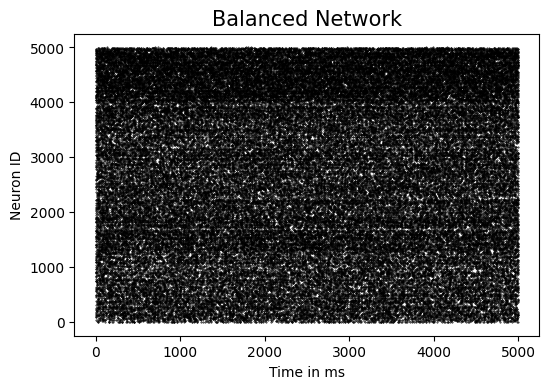

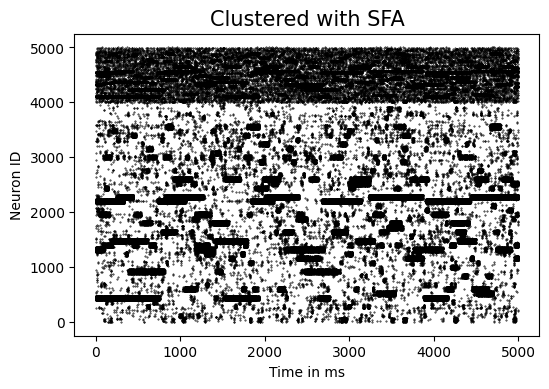

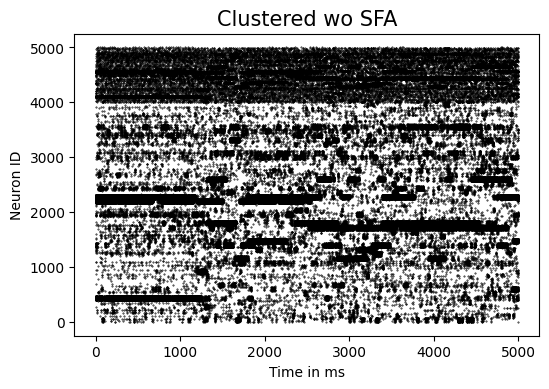

In [44]:
import matplotlib.pyplot as plt

#create list for all three raster plots
rasterplots = []

#for all models
for i in range(len(models)):

  #create figure
  figure = plt.figure(dpi=100)
  #create subplot
  ax = figure.add_subplot(1,1,1)
  #plot both dimensions of x (time, neuron id)
  plt.plot(time_range_models[i][0],time_range_models[i][1],'.k',markersize = 0.8) 

  #label the plot
  ax.set_xlabel('Time in ms', fontsize = 10)
  ax.set_ylabel('Neuron ID', fontsize = 10)
  ax.set_title(model_names[i], fontsize = 15)

  #store plots in list
  rasterplots.append(figure)


### Create spike count matrix

In [40]:
!mkdir spike_count_matrix

In [7]:
import numpy as np

#define a time window (in milliseconds)
window = 10

#calculate number of intervals based on recorded time span / time window
intervals = int(np.max(models_x[i][0, :]+ 1)/window)

#define which neurons to focus on (here: only excitatory neurons 0 - 4000)
neurons = int(np.max(models_x[i][1, :])+1) - 1000

#how many intervals do we have?
print("We have " + str(intervals) + " intervals, each " + str(window) + "ms long. \n")

spike_count_matrix = np.zeros((len(models), intervals, neurons))

#for every model
for i in range(len(models)):
  #get the data of the current model
  current_model_x = np.array(models_x[i])

  #create a zeros array with size time * neurons (5000*4000)
  spike_counts = np.zeros((intervals, neurons))

  #for every interval
  for j in range(intervals):

    #get the indices of time points within the current interval
    interval_time_points = np.where(np.logical_and(window*j <= current_model_x[0], current_model_x[0] < window*(j+1)))

    #get data indexed by current interval
    interval_data = current_model_x[1][interval_time_points]
    
    #for every neuron
    for k in range(neurons):

        #get the indices of the current neuron within the defined time interval
        current_neuron = np.where(interval_data == k)

        #get the number of spikes based on the amount of neuron indices within the defined time interval
        spikes = current_neuron[0].shape[0]

        #add spikes number to spike count matrix
        spike_counts[j, k] = spikes
  
  #add spike count matrix for every model
  spike_count_matrix[i] = spike_counts

#print data
print("The spike count matrix has the shape: " + str(spike_count_matrix.shape) + " representing " + 
      str(spike_count_matrix.shape[0]) + " models, " + str(spike_count_matrix.shape[1]) + " intervals, and " + str(spike_count_matrix.shape[2]) + " neurons. \n")
print("Spike count matrix: \n")
print(spike_count_matrix)

We have 30000 intervals, each 10ms long. 



KeyboardInterrupt: ignored

In [ ]:
from matplotlib.transforms import offset_copy

if intervals > 5: 
  intervals_to_plot = 5

#initiate figure and axes with specific size, rows = number of models, columns = number of intervals
fig, axes = plt.subplots(figsize= (25, 10), nrows=len(models), ncols=intervals_to_plot)

#define title for columns and rows (intervals and model names)
cols = ['Interval {}'.format(int(col+1)) for col in range(intervals_to_plot)]
rows = ['{}'.format(row) for row in model_names]

#define x and y axes of each subplot (neurons and spike count)
plt.setp(axes.flat, xlabel='neurons', ylabel='spike count')

#define pad (required for spacing between subplots and labels)
pad = 5 # in points

#label columns
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
#labels rows
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#arrange subplots 
fig.tight_layout()
# tight_layout doesn't take labels into account 
# more space needed:
fig.subplots_adjust(left = 0.15, top = 0.95)

#define colors for different models
colors = ['b', 'c', 'g']

#for every interval
for interval in range(intervals_to_plot):
  #for every model
  for model in range(len(models)):
    #make subplots, intervals in columns, models in rows, different color for every model
    #y axis: spike count (based on spike count matrix)
    #x axis: neurons (based on max. neuron id)
    axes[model, interval].plot(range(neurons), spike_count_matrix[model][interval], colors[model])

#show the figure
plt.show()

##PCA

In [ ]:
#imports required for pca
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Generate dataframe:

In [ ]:
#define titles for columns and rows in the dataframe that will be generated from the spike count matrix
cols = ['Neuron{}'.format(int(col+1)) for col in range(neurons)] #rows represent the neurons (= features)
rows = ['Interval{}'.format(int(row+1)) for row in range(intervals)] #columns represent the time intervals/time bins (= samples)

#create list for the data to be analyzed for each model
models_data = []

#for every model
for i in range(len(models)):
  #create a dataframe from the spike count matrix
  current = spike_count_matrix[i]
  data = pd.DataFrame(data = current, index = rows, columns = cols)
  #add the dataframe to the list (containing one dataframe per model)
  models_data.append(data)

#exemplarily show the dataframe for the second model
models_data[2].head(intervals)

In [ ]:
silent_neurons = []
all_models_silent = []

for model in range(len(models)):
  model_silent_neurons = []
  for neuron in range(neurons):
    if models_data[model].iloc[:, neuron].sum(0) == 0:
      model_silent_neurons.append(neuron+1)
  silent_neurons.append(model_silent_neurons)

In [ ]:
len(silent_neurons[0]), len(silent_neurons[1]), len(silent_neurons[2])

In [ ]:
for model in range(len(models)):
  for neuron_number in range(len(silent_neurons[model])):
    neuron = silent_neurons[model][neuron_number]
    del models_data[model]["Neuron" + str(neuron)]

In [ ]:
models_data[2].head()

In [ ]:
clone_models_data = models_data

In [ ]:
min_neurons = np.min([clone_models_data[0].shape[1], clone_models_data[1].shape[1], clone_models_data[2].shape[1]])

In [ ]:
shortened_data = []

for model in range(len(models)):
  keep_sample = clone_models_data[model].sample(min_neurons, axis = 'columns')
  shortened_data.append(keep_sample)

In [ ]:
shortened_data[2].head(intervals)

In [ ]:
data_list = [models_data, shortened_data]

###Perform PCA:

PCA chooses the minimum number of principal components such that a certain percentage of the variance is retained:

In [ ]:
#create list for the pca results for each model
pca_results = []
#create list for the eigenvalues for each model
eigenvalues = []
#create list for the variance ratio for each model
variance_ratio = []
#create list for the number of principal components for each model (using a certain variance)
n_components = []
#create list for the cumulative variance
cumulative_variance = []


In [ ]:
#initiate pca
pca = PCA()

In [ ]:
#for every model
for i in range(len(models)): 
  #standardize data: transform the data onto unit scale (mean = 0 and variance = 1)
  standardized = StandardScaler().fit_transform(models_data[i])
  #fit the data
  pca.fit(standardized)

  #add eigenvalues to eigenvalue list
  eigenvalues.append(pca.explained_variance_)
  #add explained variance ratio to variance ratio list
  variance_ratio.append(pca.explained_variance_ratio_)

  #get the pca results
  final_data = pca.transform(models_data[i])
  #add the resulting data to the list of results for each model
  pca_results.append(final_data)

  #calculate cumulative variance:

  #set cumulative to zero for every new model
  cumulative = 0
  #create empty array for cumulative variance of the current model
  current_cumulative = np.zeros(len(variance_ratio[i]))
  #for every principal component (all variance values)
  for variance in range(len(variance_ratio[i])):
    #add the current components variance to the cumulative value
    cumulative += variance_ratio[i][variance]
    #set the current models cumulative value to the current cumulative
    current_cumulative[variance] = cumulative
  #append current models cumulative to list of all models cumulative variance
  cumulative_variance.append(current_cumulative)

  #calculate the amount of principal components describing a defined amount of explained variance (e.g. 90%)
  current_components = np.where(cumulative_variance[i] < 0.9)
  n_components.append(int(current_components[0].shape[0]) + 1)
  #print the number of principal components for each model
  print("Model " + str(i) + " has " + str(n_components[i]) + " principal components.")


####PCA visualization 2D

In [ ]:
#initiate figure and axes
fig, axes = plt.subplots(figsize= (20, 5), nrows=1, ncols=len(models))

#define title for columns 
cols = ['{}'.format(col) for col in model_names]

#define x and y axes of each subplot (principal components)
plt.setp(axes.flat, xlabel='principal component 1', ylabel='principal component 2')

#define pad (required for spacing between subplots and labels)
pad = 5 # in points

#label columns
for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

#arrange subplots 
fig.tight_layout()
# tight_layout doesn't take labels into account 
# more space needed:
fig.subplots_adjust(left = 0, top = 0.95, wspace = 0.2)

#define colors for different models4/1AY0e-g7tW0xNyRtqiRWK1yrVl-a6dD7HG0XWDboOmJUpxJhBkIhBi-McerE

#for every model
for model in range(len(models)):
  #make subplots, intervals in columns, models in rows, different color for every model
  #y axis: principal component 2
  #x axis: principal component 1

  axes[model].scatter(pca_results[model][:, 0],pca_results[model][:, 1], color = colors[model], marker = ".")

#show the figure
plt.show() 

###t-SNE plot

Make t-SNE projections:

In [ ]:
from sklearn.manifold import TSNE

#create by list for projections
projections = []

#for every model
for model in range(len(models)):
  #initiate tsne using 2 components 
  tsne = TSNE(n_components=2, random_state=0)
  #make projections and add projections to list of projections for every model
  projections.append(tsne.fit_transform(models_data[model]))

Plot t-SNE projections:

In [ ]:
#initiate figure and axes
fig, axes = plt.subplots(figsize= (20, 5), nrows=1, ncols=len(models))

#define title for columns 
cols = ['{}'.format(col) for col in model_names]

#define x and y axes of each subplot (projections based on t-SNE)
plt.setp(axes.flat, xlabel='0', ylabel='1')

#define pad (required for spacing between subplots and labels)
pad = 5 # in points

#label columns
for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

#arrange subplots 
fig.tight_layout()
# tight_layout doesn't take labels into account 
# more space needed:
fig.subplots_adjust(left = 0, top = 0.95, wspace = 0.2)

#define colors for different models
colors = ['b', 'c', 'g']

#for every model
for model in range(len(models)):
  #make subplots, using a different color for every model

  axes[model].scatter(projections[model][:, 0],projections[model][:, 1], color = colors[model], marker = ".")

#show the figure
plt.show() 

###Plot PCA results

In [ ]:
#initiate figure and axes
fig, axes1 = plt.subplots(figsize= (20, 4), nrows=1, ncols=len(models), sharey = True)

#define title for columns 
cols = ['{}'.format(col) for col in model_names]

#define x and y axes of each subplot (principal components and explained variance)
plt.setp(axes1.flat, xlabel='principal components', ylabel='explained variance [%]')

#define pad (required for spacing between subplots and labels)
pad = 5 # in points

#label columns
for ax, col in zip(axes1, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

#arrange subplots 
fig.tight_layout()
# tight_layout doesn't take labels into account 
# more space needed:
fig.subplots_adjust(left = 0, top = 0.95, wspace = 0.3)

#define colors for different models
colors = ['b', 'c', 'g']

#for every model
for model in range(len(models)):
  axis2 = axes1[model].twinx()
  #make subplots, intervals in columns, models in rows, different color for every model
  #y axis: spike count (based on spike count matrix)
  #x axis: neurons (based on max. neuron id)

  axes1[model].bar(range(intervals),variance_ratio[model][:]*100, width = 1, color = colors[model])
  axis2.plot(range(intervals), cumulative_variance[model]*100, color = "k")
  axis2.set_ylabel('cumulative variance [%]')

#show the figure
plt.show() 

### Comparison of results based on PCA and dimensionality measure used by Mazzucato et al.

In [ ]:
#for every model
for i in range(len(models)): 
  #how many principal components do we have?
  print("Model " + str(i) + " has " + str(n_components[i]) + " principal components.")
  #set the current value to zero
  current = 0

  #for every principal component
  for j in range(n_components[i]):
    #(eigenvalue/total amount of variance explained)²
    squared = (eigenvalues[i][j]/sum(eigenvalues[i][:]))**2
    #add the result to the current value
    current += squared

  #divide 1 by the sum of all results
  result = 1/current

  #print the results
  print("Model " + str(i) + " has " + str(int(result)) + " dimensions based on dimensionality measure used by Mazzucato et al.")

## Summary dimensionality reduction

In [ ]:
different_datasets = []
dataset_steps = []

for data in range(len(data_list)):

  models_data = data_list[data]

  #what sample sizes do you want to generate?

  #initiate pca
  pca = PCA()

  all_steps = []

  #every possible sample size from 1 to 99 (small steps, every sample)
  small_steps = np.linspace(1, 99, 99)
  #define big steps from 100 to 2000 (every 200)
  big_steps = np.linspace(100, 2000, 20)

  steps = np.concatenate((small_steps, big_steps))

  for model in range(len(models)):
    #get the last possible sample number
    last_step = np.array(models_data[model].shape[1])
    #concatenate all the sample sizes to one list
    all_steps.append(np.append(steps, last_step))
  
  dataset_steps.append(all_steps)

  ensemble_size = all_steps[0].shape[0]

  #define how many repeats you want to have for your random sampling
  repeats = 50

  #create list for all eigenvalues
  all_eigenvalues = []

  #for all models
  for model in range(len(models)):
    #create list for eigenvalues of each sample
    eigenvalue_samples = []

    #for all samples
    for sample in range(ensemble_size):
      #create list for all repeats of the current sample
      eigenvalue_repeats = []

      #for every repeat
      for repeat in range(repeats):
        #get a random sample of neurons of the current sample size 
        repeat_sample = models_data[model].sample(int(all_steps[model][sample]), axis = 'columns')

        #standardize data: transform the data onto unit scale (mean = 0 and variance = 1)
        standardized = StandardScaler().fit_transform(repeat_sample)
        #fit the data

        import warnings 
        with warnings.catch_warnings():
          warnings.filterwarnings('error')
          try:
            pca.fit(standardized)
          except Warning as e:
            print("Dataset " + str(data))
            print("Model " + str(model))
            print("Sample " + str(sample))
            print(repeat_sample.sum(0))
            print("Repeat " + str(repeat))
        
        #calculate eigenvalues and add to list of all repeats
        eigenvalue_repeats.append(pca.explained_variance_)
      #add lists of eigenvalues for each repeat to the list for each sample
      eigenvalue_samples.append(eigenvalue_repeats)
    #add list of eigenvalues for each sample to the list of eigenvalues for all models
    all_eigenvalues.append(eigenvalue_samples)
  
  different_datasets.append(all_eigenvalues)

In [ ]:
dataset_dimensionalities = []

for dataset in range(len(different_datasets)):

  all_eigenvalues = different_datasets[dataset]

  #create list for all dimensionality values for every model
  all_dimensionality = []

  #for every model
  for model in range(len(models)): 
    #access the eigenvalues of the current model
    current_model = all_eigenvalues[model]
    #create list for the dimensionality values of each sample
    samples = []

    #for every sample
    for sample in range(ensemble_size):
      #access the eigenvalues of the current sample
      current_sample = current_model[sample]
      #create a list for the dimensionality values of the current sample's repeats
      all_repeats = []

      #for every repeat
      for repeat in range(repeats):
        #set the current value to zero
        current = 0
        #calculate the total variance of all neuron's eigenvalues within the current sample and repeat
        total_variance = sum(current_sample[repeat][:])

        #if the total variance is not zero, calculate dimensionality:
        if total_variance != 0:
          #for every neurons within the current sample and repeat
          for neuron in range(len(current_sample[repeat])):
            #squared = (eigenvalue/total amount of variance explained)²
            squared = (current_sample[repeat][neuron]/total_variance)**2  
            #add the result to the current value
            current += squared

          #calculate dimensionality: 1 divided by current value
          dimensionality = 1/current
        
        #else (if the total variance is zero)
        else:
          print("weird...")
          #set the result to zero to avoid division by zero
          dimensionality = 0

        #add the current dimensionality to the list of all repeats  
        all_repeats.append(dimensionality)
      #calculate mean and standard deviation for all repeats of the current sample
      mean = np.mean(all_repeats[:])
      std = np.std(all_repeats[:])
      #add means and stds as a tuple to a list for all samples
      samples.append((mean, std))
    #add all dimensionality values from all samples to the list of all dimensionalities
    all_dimensionality.append(samples)

  dataset_dimensionalities.append(all_dimensionality)

In [ ]:
from operator import add
from operator import sub

for dataset in range(len(dataset_dimensionalities) + 1):

  #plot 1 graph for dataset with different number of neurons
  if dataset == 0:
    all_dimensionality = dataset_dimensionalities[0]
    all_steps = dataset_steps[0]
  #plot other graphs for dataset with same number of neurons
  else:
    all_dimensionality = dataset_dimensionalities[1]
    all_steps = dataset_steps[1]


  #define figure fig with a certain size
  fig = plt.figure(figsize = (10,6))
  #define axis, two axis, index position = 1
  ax = fig.add_subplot(1,1,1) 
  #set labels and title of figure
  ax.set_xlabel('Ensemble size', fontsize = 15)
  ax.set_ylabel('Dimensionality', fontsize = 15)
  ax.set_title('Dimensionality reduction summary', fontsize = 20)

  #define colors for different models
  colors = ['b', 'c', 'g']

  #for tuple of target and color: (target, color)
  for model in range(len(models)):
    #get lists of all means and standard deviations
    all_means = [x[0] for x in all_dimensionality[model]]
    all_std = [x[1] for x in all_dimensionality[model]]

    #calculate positive and negative error
    pos_err = list(map(add, all_means, all_std)) 
    neg_err = list(map(sub, all_means, all_std))

    #plot the data
    ax.plot(all_steps[model], all_means, color = colors[model], label = model_names[model])
    #fill area of positive and negative errors
    ax.fill_between(all_steps[model], pos_err, neg_err, facecolor = colors[model], alpha=0.3)
    plt.legend(loc = "lower right")

    #make log y scale
    if dataset == 2: 
      plt.xscale("log")